In [1]:
!pip install efficientnet_pytorch

  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9deeb1a457ffb3d0d7967019ad0265bbb8c4ef265559954236198db66f62c19d
  Stored in directory: /root/.cache/pip/wheels/63/17/7e/07f1c55a623c96ba9b291c5d2e4901afffb953b032c2470ca6
Successfully built efficientnet-pytorch


In [23]:
torchvision.models

<module 'torchvision.models' from '/opt/conda/lib/python3.8/site-packages/torchvision/models/__init__.py'>

In [1]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import display

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

from efficientnet_pytorch import EfficientNet

# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
# 여기에 코드를 작성하세요.
!git clone https://github.com/ndb796/Small-ImageNet-Validation-Dataset-1000-Classes

fatal: destination path 'Small-ImageNet-Validation-Dataset-1000-Classes' already exists and is not an empty directory.


In [3]:
%cd Small-ImageNet-Validation-Dataset-1000-Classes

/workspace/Juwan/UROP_help/Small-ImageNet-Validation-Dataset-1000-Classes


In [4]:
imsize = 256

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # 이미지 사이즈 변경
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('전체 이미지 개수:', len(val_dataset))

class_names = val_dataset.classes
print('클래스의 개수:', len(class_names))

# ImageNet 설정 파일에서 1,000개의 레이블을 불러오기
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

전체 이미지 개수: 5000
클래스의 개수: 1000


In [5]:
# 입력 데이터를 정규화(normalization)하는 클래스
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

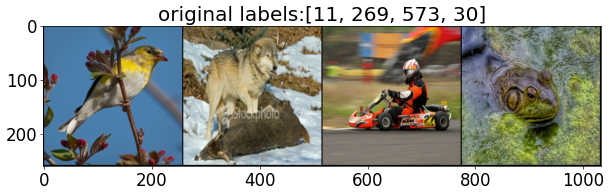

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: goldfinch, Carduelis carduelis (11)
Image #2: timber wolf, grey wolf, gray wolf, Canis lupus (269)
Image #3: go-kart (573)
Image #4: bullfrog, Rana catesbeiana (30)


In [6]:
# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow_batch(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()


# 검증 데이터셋에서 하나의 배치를 불러와 보기
iterator = iter(val_dataloader)

# 현재 배치에 포함된 이미지를 출력하기
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

In [7]:
# 이 코드는 바꾸실 수 없습니다.
black_box_model = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.inception_v3(pretrained=True)
).to(device).eval()

In [8]:
# 커스텀 공격 클래스 예시
class CustomAttack:
    def __init__(self, eps, alpha, iters):
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
    
    def perturb(self, model, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
        perturbation = torch.empty_like(images).uniform_(-self.eps, self.eps)
        perturbation.to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()

        for i in range(self.iters):
            # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
            perturbation.requires_grad = True

            # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
            current = torch.clamp(images + perturbation, min=0, max=1)
            outputs = model(current) # 모델의 판단 결과 확인

            # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
            model.zero_grad()
            cost = attack_loss(outputs, labels).to(device)
            cost.backward()

            # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
            diff = self.alpha * perturbation.grad.sign()
            # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
            perturbation = torch.clamp(perturbation + diff, min=-self.eps, max=self.eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation

In [9]:
# 커스텀 공격 클래스 예시
class CustomAttack_ensemble:
    def __init__(self, eps, alpha, iters, decay=1.0):
        self.eps = eps
        self.alpha = alpha
        self.iters = iters
        self.decay = decay
    
    def perturb(self, models, images, labels):
        # 이미지와 레이블 데이터를 GPU로 옮기기
        images = images.to(device)
        labels = labels.to(device)

        # 입력 이미지와 동일한 크기를 갖는 노이즈(perturbation) 생성
        # 노이즈 값은 음수가 될 수 있으므로, 평균이 0인 균등한(uniform) 랜덤 값으로 설정
        perturbation = torch.empty_like(images).uniform_(-self.eps, self.eps)
        perturbation.to(device)
        # 손실(loss) 함수 설정
        attack_loss = nn.CrossEntropyLoss()
        momentum = torch.zeros_like(images).detach().to(device)

        for i in range(self.iters):
            for model in models:
                # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
                perturbation.requires_grad = True

                # 현재 공격 이미지(원래 이미지에 노이즈를 섞고, 그 결과가 [0, 1] 범위에 속하도록 자르기)
                current = torch.clamp(images + perturbation, min=0, max=1)
                outputs = model(current) # 모델의 판단 결과 확인

                # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
                model.zero_grad()
                cost = attack_loss(outputs, labels).to(device)
                cost.backward()

                # Update adversarial images
                grad = perturbation.grad
                grad = grad / torch.mean(torch.abs(grad), dim=(1,2,3), keepdim=True)
                grad = grad + momentum*self.decay
                momentum = grad

                # 계산된 기울기(gradient)를 이용하여 손실 함수가 증가하는 방향으로 업데이트
                diff = self.alpha * grad.sign()
                # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
                perturbation = torch.clamp(perturbation + diff, min=-self.eps, max=self.eps).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

        # (최종적으로 만들어진 공격 이미지, 노이즈) 반환
        current = torch.clamp(images + perturbation, min=0, max=1)
        return current, perturbation

In [10]:
def black_box_attack_validate(model, black_box_model, attack):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        # adv_image, perturbation = attack.perturb(model, inputs, labels) # adversarial attack
        adv_image, perturbation = attack.perturb(model, inputs, labels) # adversarial attack

        outputs = black_box_model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

In [11]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

In [12]:
efficientnet_b1 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    EfficientNet.from_pretrained('efficientnet-b1')
).to(device).eval()

Loaded pretrained weights for efficientnet-b1


In [13]:
efficientnet_b2 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    EfficientNet.from_pretrained('efficientnet-b2')
).to(device).eval()

Loaded pretrained weights for efficientnet-b2


In [14]:
mobilenet_v2 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.mobilenet_v2(pretrained=True)
).to(device).eval()

In [15]:
regnet400 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.regnet_x_400mf(pretrained=True)
).to(device).eval()

In [16]:
resnet50_2 = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.wide_resnet50_2(pretrained=True)
).to(device).eval()

In [17]:
efficientnet_b7 = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.efficientnet_b7(pretrained=True)
).to(device).eval()

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The dimension of an image tensor: torch.Size([3, 256, 256])
[Prediction Result Examples]


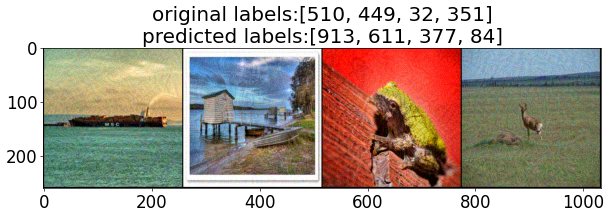

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: container ship, containership, container vessel (510)
Image #2: boathouse (449)
Image #3: tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui (32)
Image #4: hartebeest (351)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: wreck (913)
Image #2: jigsaw puzzle (611)
Image #3: marmoset (377)
Image #4: peacock (84)


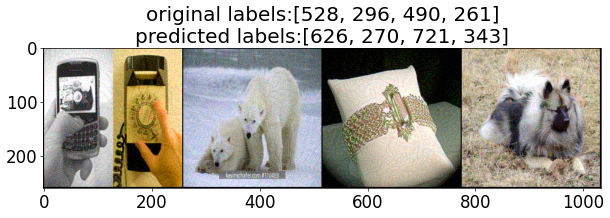

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: dial telephone, dial phone (528)
Image #6: ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus (296)
Image #7: chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour (490)
Image #8: keeshond (261)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: lighter, light, igniter, ignitor (626)
Image #6: white wolf, Arctic wolf, Canis lupus tundrarum (270)
Image #7: pillow (721)
Image #8: warthog (343)
[Step #0] Loss: 0.6957 Accuracy: 0.0000% Time elapsed: 3.5278s (total 16 images)
[Step #10] Loss: 0.6341 Accuracy: 3.9773% Time elapsed: 27.2587s (total 176 images)
[Step #20] Loss: 0.6220 Accuracy: 3.2738% Time elapsed: 50.8417s (total 336 images)
[Step #30] Loss: 0.6090 Accuracy: 3.4274% Time elapsed: 74.3373s (total 496 images)
[Step #40] Loss: 0.6126 Accuracy: 3.2012% Time elapsed: 97.9066s (total 656 images)
[Step #50] Loss: 0.6142 Accuracy: 3.4314% Time elapsed: 121.3988s (total 816 images)
[Step #60] Los

In [18]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = CustomAttack_ensemble(eps=16/255, alpha=4/255, iters=4, decay=1.0) # 공격용 파라미터 설정
black_box_attack_validate([efficientnet_b1,mobilenet_v2, regnet400, resnet50_2,efficientnet_b2,efficientnet_b7], black_box_model, custom_attack)